In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Подключение к БД

In [2]:
load_dotenv(dotenv_path=r'C:\Users\User\Downloads\Пет-проекты\marketplace_users_data\config.env')  # Загрузка переменных из .env

db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)

In [8]:
query_purchases = """
    SELECT *
    FROM purchases;
"""

In [9]:
df_purchases = pd.read_sql(query_purchases, engine, parse_dates=['purchase_date'])
df_purchases

,id,user_id,purchase_date,amount,category
0,1,21,2025-08-18,896.880,BOOKS
1,2,332,2025-03-25,840.580,UNKNOWN CATEGORY
2,3,398,2025-04-01,855.720,UNKNOWN CATEGORY
3,4,405,2024-12-09,504.095,ELECTRONICS
4,5,263,2024-03-17,590.230,SPORTS
...,...,...,...,...,...
2995,2996,471,2024-11-03,22.430,TOYS
2996,2997,119,2024-02-04,498.400,COSMETICS
2997,2998,280,2025-03-17,155.820,COSMETICS
2998,2999,265,2024-10-12,867.040,FOOD


# ABC - анализ

### Проведение этого ABC-анализа поможет распределить категории в три группы (A, B, C) в зависимости от их выручки.

Создадим датафрейм, где сгруппируем датафрейм по категориям и рассчитаем выручку от каждой категории

In [11]:
df_purchases_revenue = df_purchases.groupby('category').agg(revenue = ('amount','sum'),).reset_index()
df_purchases_revenue

,category,revenue
0,BOOKS,190466.795
1,CLOTHING,197637.685
2,COSMETICS,174954.025
3,ELECTRONICS,188053.585
4,FOOD,168463.070
5,SPORTS,171913.410
6,TOYS,166406.350
7,UNKNOWN CATEGORY,253160.960


Отсортируем пользователей по выручке

In [12]:
df_purchases_revenue = df_purchases_revenue.sort_values('revenue', ascending=False).reset_index(drop=True)
df_purchases_revenue

,category,revenue
0,UNKNOWN CATEGORY,253160.960
1,CLOTHING,197637.685
2,BOOKS,190466.795
3,ELECTRONICS,188053.585
4,COSMETICS,174954.025
5,SPORTS,171913.410
6,FOOD,168463.070
7,TOYS,166406.350


Рассчитаем накопительную выручку

In [13]:
df_purchases_revenue['cumsum_revenue'] = df_purchases_revenue['revenue'].cumsum()
df_purchases_revenue

,category,revenue,cumsum_revenue
0,UNKNOWN CATEGORY,253160.960,253160.960
1,CLOTHING,197637.685,450798.645
2,BOOKS,190466.795,641265.440
3,ELECTRONICS,188053.585,829319.025
4,COSMETICS,174954.025,1004273.050
5,SPORTS,171913.410,1176186.460
6,FOOD,168463.070,1344649.530
7,TOYS,166406.350,1511055.880


Оперелим её долю в общей выручке

In [14]:
df_purchases_revenue['cumsum_revenue_per'] = df_purchases_revenue['cumsum_revenue'] / df_purchases_revenue['revenue'].sum()
df_purchases_revenue

,category,revenue,cumsum_revenue,cumsum_revenue_per
0,UNKNOWN CATEGORY,253160.960,253160.960,0.167539
1,CLOTHING,197637.685,450798.645,0.298334
2,BOOKS,190466.795,641265.440,0.424382
3,ELECTRONICS,188053.585,829319.025,0.548834
4,COSMETICS,174954.025,1004273.050,0.664617
5,SPORTS,171913.410,1176186.460,0.778387
6,FOOD,168463.070,1344649.530,0.889874
7,TOYS,166406.350,1511055.880,1.000000


Определим группу для каждой выручки (**A**, **B** или **C**)

In [15]:
def abc_group(cumsum_revenue_per):
    return 'A' if cumsum_revenue_per <= 0.8 else 'B' if cumsum_revenue_per <=0.9 else 'C'
df_purchases_revenue['ABC'] = df_purchases_revenue['cumsum_revenue_per'].apply(abc_group)
df_purchases_revenue

,category,revenue,cumsum_revenue,cumsum_revenue_per,ABC
0,UNKNOWN CATEGORY,253160.960,253160.960,0.167539,A
1,CLOTHING,197637.685,450798.645,0.298334,A
2,BOOKS,190466.795,641265.440,0.424382,A
3,ELECTRONICS,188053.585,829319.025,0.548834,A
4,COSMETICS,174954.025,1004273.050,0.664617,A
5,SPORTS,171913.410,1176186.460,0.778387,A
6,FOOD,168463.070,1344649.530,0.889874,B
7,TOYS,166406.350,1511055.880,1.000000,C


In [16]:
df_purchases_revenue['ABC'].value_counts(normalize=True) * 100

ABC
A    75.0
B    12.5
C    12.5
Name: proportion, dtype: float64

Данные ABC-анализа по категориям и выручке показывают, что:

*   Категории группы A (UNKNOWN CATEGORY, CLOTHING, BOOKS, ELECTRONICS, COSMETICS, SPORTS) приносит 75% выручки — это ключевая группа, обеспечивающая основной доход компании. За ней нужно тщательно следить, поддерживать наличие товаров и стимулировать продажи.
*   Категория FOOD относится к группе B и приносит 12.5% выручки, это средняя группа товаров, которые приносят значимый, но менее критичный доход. Рекомендуется развивать и улучшать продажи этой категории.
*  Категория TOYS находится в группе C и приносит 12.5% выручки, эта группа обычно включает менее востребованные товары, на которые стоит обращать меньше ресурсов или рассматривать возможность оптимизации ассортимента.

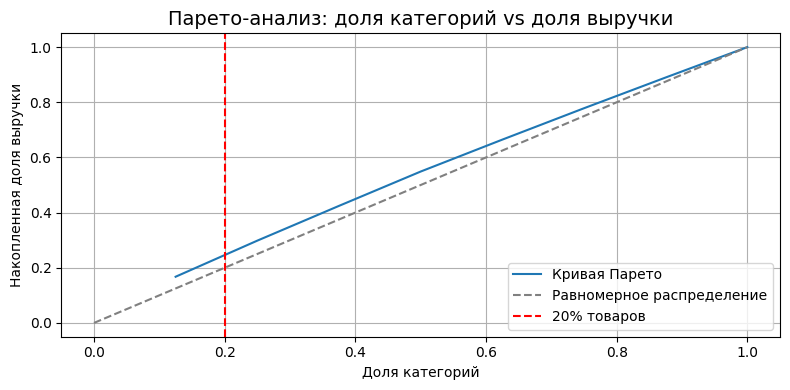

In [18]:
df_purchases_revenue['ngrugs_share'] = (df_purchases_revenue.index + 1) / len(df_purchases_revenue)

plt.figure(figsize=(8, 4))
sns.lineplot(x=df_purchases_revenue['ngrugs_share'], y=df_purchases_revenue['cumsum_revenue_per'], label='Кривая Парето')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Равномерное распределение')
plt.axvline(x=0.2, color='red', linestyle='--', label='20% товаров')

plt.title('Парето-анализ: доля категорий vs доля выручки', fontsize=14)
plt.xlabel('Доля категорий')
plt.ylabel('Накопленная доля выручки')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Анализ структуры выручки по категориям через график Парето подтверждает принцип Парето, где небольшая часть ассортимента (Категория A) генерирует большую часть дохода. Фокус бизнеса должен быть на максимальном обслуживании категории A и развитии категории B, а товары из категории C требуют пересмотра или сокращения вложений. Это помогает повысить операционную эффективность и прибыльность бизнеса.

# XYZ-анализ

Данный анализ поможет понять, как изменяется выручка с каждой категории по месяцам, выделить стабильные и непредсказуемые категории

In [19]:
df_purchases['month_purchase'] = df_purchases['purchase_date'].dt.month
df_purchases

,id,user_id,purchase_date,amount,category,month_purchase
0,1,21,2025-08-18,896.880,BOOKS,8
1,2,332,2025-03-25,840.580,UNKNOWN CATEGORY,3
2,3,398,2025-04-01,855.720,UNKNOWN CATEGORY,4
3,4,405,2024-12-09,504.095,ELECTRONICS,12
4,5,263,2024-03-17,590.230,SPORTS,3
...,...,...,...,...,...,...
2995,2996,471,2024-11-03,22.430,TOYS,11
2996,2997,119,2024-02-04,498.400,COSMETICS,2
2997,2998,280,2025-03-17,155.820,COSMETICS,3
2998,2999,265,2024-10-12,867.040,FOOD,10


Соберём таблицу с выручкой по каждой категории по каждому месяцу (временной ряд продаж):

In [20]:
monthly_amount = df_purchases.groupby(['category', 'month_purchase']).agg(revenue = ('amount', 'sum'),).reset_index()
monthly_amount

,category,month_purchase,revenue
0,BOOKS,1,13941.075
1,BOOKS,2,9468.935
2,BOOKS,3,12562.390
3,BOOKS,4,20558.840
4,BOOKS,5,12194.800
...,...,...,...
91,UNKNOWN CATEGORY,8,58255.685
92,UNKNOWN CATEGORY,9,17968.600
93,UNKNOWN CATEGORY,10,17855.060
94,UNKNOWN CATEGORY,11,12195.855


Для наглядности преобразуем получившуюся таблицу в сводную.

In [21]:
month_matrix = monthly_amount.pivot(index='category', columns='month_purchase', values='revenue').fillna(0)
month_matrix.head(10)

month_purchase,1,2,3,4,5,6,7,8,9,10,11,12
category,,,,,,,,,,,,
BOOKS,13941.075,9468.935,12562.390,20558.840,12194.800,15771.925,13116.540,32816.240,15115.015,15926.580,10190.500,18803.955
CLOTHING,15847.960,17527.340,20271.790,9517.920,11304.710,11458.955,13453.500,39243.435,13671.890,10749.200,19882.755,14708.230
COSMETICS,12322.825,15487.140,12974.650,14199.355,19898.375,11797.995,10928.285,28933.425,10887.650,15552.785,7661.600,14309.940
ELECTRONICS,17422.405,15574.575,13275.455,16359.010,12015.570,12323.770,19007.345,32278.410,9302.725,11098.575,11407.280,17988.465
FOOD,7053.420,12530.595,15429.870,13856.535,10195.910,11995.390,11280.755,37118.245,11262.455,16199.445,9604.655,11935.795
SPORTS,11909.275,14112.760,17471.725,7846.295,11278.370,13124.950,11280.365,28216.285,13834.785,12970.560,11922.425,17945.615
TOYS,13732.580,15413.015,10028.595,10457.740,13772.850,12325.800,15020.115,24212.740,10408.730,13118.845,14068.445,13846.895
UNKNOWN CATEGORY,13685.060,18008.045,22637.225,22696.505,26276.750,14596.890,13631.060,58255.685,17968.600,17855.060,12195.855,15354.225


Рассчитаем среднее сумму покупок, стандартное отклонение и коэффициент вариации:

In [22]:
matrix_clean = month_matrix.replace(0, np.nan)
month_stat = pd.DataFrame({
    'category' : matrix_clean.index,
    'avg_revenue' : matrix_clean.mean(axis=1),
    'std_revenue' : matrix_clean.std(axis=1)
}).reset_index(drop=True)
month_stat['cv'] = month_stat['std_revenue'] / month_stat['avg_revenue']
month_stat

,category,avg_revenue,std_revenue,cv
0,BOOKS,15872.232917,6232.839358,0.392688
1,CLOTHING,16469.807083,7972.207598,0.484050
2,COSMETICS,14579.502083,5448.412817,0.373704
3,ELECTRONICS,15671.132083,6073.818941,0.387580
4,FOOD,14038.589167,7679.430518,0.547023
5,SPORTS,14326.117500,5149.333306,0.359437
6,TOYS,13867.195833,3718.176006,0.268127
7,UNKNOWN CATEGORY,21096.746667,12459.043761,0.590567


Присвоим группы коэффициенту вариации

In [23]:
month_stat['XYZ'] = month_stat['cv'].apply(lambda x: 'X' if x <= 0.3 else 'Y' if x <=0.7 else 'Z')
month_stat


,category,avg_revenue,std_revenue,cv,XYZ
0,BOOKS,15872.232917,6232.839358,0.392688,Y
1,CLOTHING,16469.807083,7972.207598,0.484050,Y
2,COSMETICS,14579.502083,5448.412817,0.373704,Y
3,ELECTRONICS,15671.132083,6073.818941,0.387580,Y
4,FOOD,14038.589167,7679.430518,0.547023,Y
5,SPORTS,14326.117500,5149.333306,0.359437,Y
6,TOYS,13867.195833,3718.176006,0.268127,X
7,UNKNOWN CATEGORY,21096.746667,12459.043761,0.590567,Y


In [24]:
month_stat['XYZ'].value_counts(normalize=True) * 100

XYZ
Y    87.5
X    12.5
Name: proportion, dtype: float64

XYZ-анализ по категориям показывает распределение по стабильности и предсказуемости выручки:

*   Большинство категорий (87.5%) относятся к группе Y, что означает средний уровень стабильности выручки с коэффициентом вариации (CV) около 0.37–0.59. Такие товары продаются относительно регулярно, но с некоторой вариабельностью.
*   Категория TOYS выделена группой X (12.5%), характеризующейся наибольшей стабильностью с низким CV (~0.27), то есть продажи этой категории наиболее предсказуемы и равномерны.


### Выводы:

1. Категории с меткой Y требуют умеренного внимания к запасам с возможной корректировкой на сезонность или непредсказуемость спроса.

2. Категории X подходят для точного планирования закупок из-за стабильных продаж.

# Объединение ABC и XYZ анализа

In [25]:
results = df_purchases_revenue[['category', 'ABC']].merge(month_stat[['category', 'XYZ']], on='category', how='left')
results['ABC_XYZ'] = results['ABC'] + results['XYZ']
results

,category,ABC,XYZ,ABC_XYZ
0,UNKNOWN CATEGORY,A,Y,AY
1,CLOTHING,A,Y,AY
2,BOOKS,A,Y,AY
3,ELECTRONICS,A,Y,AY
4,COSMETICS,A,Y,AY
5,SPORTS,A,Y,AY
6,FOOD,B,Y,BY
7,TOYS,C,X,CX


In [26]:
results['ABC_XYZ'].value_counts(normalize=True) * 100

ABC_XYZ
AY    75.0
BY    12.5
CX    12.5
Name: proportion, dtype: float64

# Выводы и рекомендации

## Выводы

На основе проведенного ABC-XYZ анализа можно сделать следующие выводы:
*   AY (категория A по выручке и Y по стабильности) составляет 75% — это наиболее важная и относительно стабильная группа клиентов или товаров, которая обеспечивает основную прибыль компании и требует внимания к сезонности и управлению запасами.
*   BY — 12.5% — средняя по значимости и стабильности группа, которая приносит умеренный доход и характеризуется средней вариабельностью спроса.
*   CX — 12.5% — наименее значимая группа по доходу, но с высокой стабильностью спроса.

## Рекомендации

1. Для товаров и клиентов __группы AY__ (высокий вклад в выручку и средняя стабильность) — минимизация запасов с частыми, небольшими поставками от надежных поставщиков. Это позволит держать склад оптимально наполненным и избежать излишков.

2. Для __группы BY__ (средний вклад и средняя стабильность) необходим более внимательный мониторинг спроса и частые обновления прогнозов, чтобы избежать дефицита и излишков.

3. Для __группы CX__ (низкий вклад, но высокая стабильность) — максимизация запасов, где важно иметь достаточный резерв, минимизируя риски отсутствия товара.